In [1]:
!pip install gym

In [2]:
!pip install gym==0.19

In [3]:
!pip install atari-py

In [4]:
!python -m atari_py.import_roms '/Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms'

copying koolaid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kool-Aid Man (Kool Aid Pitcher Man) (1983) (M Network, Stephen Tatsumi, Jane Terjung - Kool Aid) (MT4648) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/koolaid.bin
copying alien.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/alien.bin
copying demon_attack.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Demon Attack (Death from Above) (1982) (Imagic, Rob Fulop) (720000-200, 720101-1B, 720101-1C, IA3200, IA3200C, IX-006-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/demon_attack.bin
copying crazy_climber.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Crazy Climber (1983) (Atari - Rokl

copying space_invaders.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/space_invaders.bin
copying up_n_down.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Up 'n Down (1984) (SEGA - Beck-Tech, Steve Beck, Phat Ho) (009-01) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/up_n_down.bin
copying galaxian.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Galaxian (1983) (Atari - GCC, Mark Ackerman, Tom Calderwood, Glenn Parker) (CX2684) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/galaxian.bin
copying riverraid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/River Raid (1982) (Activision, Carol Shaw) (AX-020, AX-020-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python

In [5]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
start_time=time.time()

# hyperparameters
H = 800 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save_800_1e-4.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save_800_1e-4.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
end_time=time.time()
td_model=end_time-start_time
print('Time difference for model is %s seconds:' %(td_model))

        

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_6407/165281632.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -21.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game fini

ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: 1.0 !!!!!!!!
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.971545106111446
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
e

ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.89786586707823
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: gam

ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.81080120301876
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: gam

ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: 1.0 !!!!!!!!
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.762206306481577
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
e

ep 48: game finished, reward: -1.0
ep 48: game finished, reward: -1.0
ep 48: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.66774431074463
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.671066867637187

ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: 1.0 !!!!!!!!
ep 58: game finished, reward: 1.0 !!!!!!!!
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.584489811439266
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward

ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.565506113282144
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
e

ep 77: game finished, reward: -1.0
ep 77: game finished, reward: -1.0
ep 77: game finished, reward: 1.0 !!!!!!!!
ep 77: game finished, reward: -1.0
ep 77: game finished, reward: -1.0
ep 77: game finished, reward: -1.0
ep 77: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.51716457277992
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: 1.0 !!!!!!!!
ep 78: game finished, reward: -1.0
ep 78: game finished, reward:

ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
ep 87: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.525459774524826
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: ga

ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: 1.0 !!!!!!!!
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
ep 97: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.494152670247765
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
e

ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: 1.0 !!!!!!!!
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.53252074228102
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game

ep 116: game finished, reward: -1.0
ep 116: game finished, reward: -1.0
ep 116: game finished, reward: -1.0
ep 116: game finished, reward: -1.0
ep 116: game finished, reward: -1.0
ep 116: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.535001289760782
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finish

ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.531128957579366
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: 1.0 !!!!!!!!
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: gam

ep 135: game finished, reward: -1.0
ep 135: game finished, reward: -1.0
ep 135: game finished, reward: -1.0
ep 135: game finished, reward: -1.0
ep 135: game finished, reward: -1.0
ep 135: game finished, reward: -1.0
ep 135: game finished, reward: -1.0
ep 135: game finished, reward: -1.0
ep 135: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.48528866992154
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finishe

ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: 1.0 !!!!!!!!
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.47656570678109
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game

ep 154: game finished, reward: -1.0
ep 154: game finished, reward: -1.0
ep 154: game finished, reward: 1.0 !!!!!!!!
ep 154: game finished, reward: -1.0
ep 154: game finished, reward: -1.0
ep 154: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.463308101741053
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: gam

ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: 1.0 !!!!!!!!
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: 1.0 !!!!!!!!
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.419577155077686
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 

ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.372825197637937
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finish

ep 182: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.38832765341183
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.394444376877715
ep 184: game finished, reward: -1.0
ep 184: gam

ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.37033946522581
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finishe

ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.348703480878847
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
resetting env. epis

ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: 1.0 !!!!!!!!
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.34294168564692
ep 212: game finished, reward: -1.0
ep 212: game finished, reward: 1.0 !!!!!!!!
ep 212: game finished, reward: -1.0
ep 212: game finished, reward: -1.0
ep 212: game finished, reward: -1.0
ep 212: game finished, reward: -1.0
ep 212: game finished, reward: -1.0
ep 212: game finished, reward: -1.0
ep 2

ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.322609649592657
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: 1.0 !!!!!!!!
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: gam

ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: 1.0 !!!!!!!!
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.31117139136997
ep 231: game finished, reward: -1.0
ep 231: game finished, reward: -1.0
ep 231: game finished, reward: -1.0
ep 231: game finished, reward: -1.0
ep 231: game

ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.294267167300177
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finish

ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: 1.0 !!!!!!!!
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.32283101576209
ep 250: game finished, reward: -1.0
ep 250: game finished, reward: -1.0
ep 250: game finished, reward: -1.0
ep 250: game finished, reward: -1.0
ep 250: game

ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.342385493337698
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finish

ep 268: game finished, reward: 1.0 !!!!!!!!
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: 1.0 !!!!!!!!
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: 1.0 !!!!!!!!
ep 268: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.29907649598355
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -

ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
ep 277: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.29253603394322
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finishe

ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: 1.0 !!!!!!!!
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.301954489584613
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: gam

ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: 1.0 !!!!!!!!
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
ep 296: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.285267022029956
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: 1.0 !!!!!!!!
ep 297: game finished, reward: -1.0
ep 

ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
ep 306: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.307094479429978
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finish

ep 315: game finished, reward: -1.0
ep 315: game finished, reward: -1.0
ep 315: game finished, reward: 1.0 !!!!!!!!
ep 315: game finished, reward: 1.0 !!!!!!!!
ep 315: game finished, reward: -1.0
ep 315: game finished, reward: -1.0
ep 315: game finished, reward: -1.0
ep 315: game finished, reward: -1.0
ep 315: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.28927242160559
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
ep 3

ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: 1.0 !!!!!!!!
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
ep 325: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.328680743916838
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: gam

ep 334: game finished, reward: -1.0
ep 334: game finished, reward: -1.0
ep 334: game finished, reward: -1.0
ep 334: game finished, reward: -1.0
ep 334: game finished, reward: -1.0
ep 334: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.300742716989774
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: 1.0 !!!!!!!!
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: 1.0 !!!!!!!!
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 

ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
ep 344: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.283424585982097
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finish

ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
ep 353: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.229613051616777
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: 1.0 !!!!!!!!
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: gam

ep 362: game finished, reward: -1.0
ep 362: game finished, reward: -1.0
ep 362: game finished, reward: -1.0
ep 362: game finished, reward: -1.0
ep 362: game finished, reward: 1.0 !!!!!!!!
ep 362: game finished, reward: -1.0
ep 362: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.210040730415216
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 363: game finished, reward: -1.0
ep 

ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: -1.0
ep 372: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.199390117150326
ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
ep 373: gam

ep 381: game finished, reward: -1.0
ep 381: game finished, reward: -1.0
ep 381: game finished, reward: -1.0
ep 381: game finished, reward: -1.0
ep 381: game finished, reward: -1.0
ep 381: game finished, reward: -1.0
ep 381: game finished, reward: -1.0
ep 381: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21030919301197
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finished, reward: -1.0
ep 382: game finishe

ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
ep 391: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.209629076744424
ep 392: game finished, reward: -1.0
ep 392: game finished, reward: -1.0
ep 392: game finished, reward: -1.0
ep 392: game finished, reward: -1.0
ep 392: game finished, reward: -1.0
ep 392: game finish

ep 400: game finished, reward: -1.0
ep 400: game finished, reward: -1.0
ep 400: game finished, reward: 1.0 !!!!!!!!
ep 400: game finished, reward: -1.0
ep 400: game finished, reward: -1.0
ep 400: game finished, reward: -1.0
ep 400: game finished, reward: -1.0
ep 400: game finished, reward: -1.0
ep 400: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.21082513620646
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: 1.0 !!!!!!!!
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 401: game finished, reward: -1.0
ep 4

ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
ep 410: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.230058877801135
ep 411: game finished, reward: -1.0
ep 411: game finished, reward: -1.0
ep 411: game finished, reward: -1.0
ep 411: game finished, reward: -1.0
ep 411: game finished, reward: -1.0
ep 411: game finish

ep 419: game finished, reward: -1.0
ep 419: game finished, reward: -1.0
ep 419: game finished, reward: -1.0
ep 419: game finished, reward: -1.0
ep 419: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25802565472543
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: 1.0 !!!!!!!!
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game finished, reward: -1.0
ep 420: game

ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
ep 429: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.30110107456937
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finished, reward: -1.0
ep 430: game finishe

ep 438: game finished, reward: -1.0
ep 438: game finished, reward: -1.0
ep 438: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.285925735925645
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: -1.0
ep 439: game finished, reward: 1.0 !!!!!!!!
ep 439: game finished, reward: -1.0
resetting e

ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
ep 448: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.268089325503585
ep 449: game finished, reward: -1.0
ep 449: game finished, reward: -1.0
ep 449: game finished, reward: -1.0
ep 449: game finished, reward: -1.0
ep 449: game finished, reward: -1.0
ep 449: game finished, reward: -1.0
ep 449: game finished, reward: -1.0
ep 449: game finish

ep 457: game finished, reward: 1.0 !!!!!!!!
ep 457: game finished, reward: -1.0
ep 457: game finished, reward: -1.0
ep 457: game finished, reward: -1.0
ep 457: game finished, reward: -1.0
ep 457: game finished, reward: -1.0
ep 457: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.263932669658058
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: game finished, reward: -1.0
ep 458: gam

ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
ep 467: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.296652792483027
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finish

ep 476: game finished, reward: -1.0
ep 476: game finished, reward: 1.0 !!!!!!!!
ep 476: game finished, reward: -1.0
ep 476: game finished, reward: -1.0
ep 476: game finished, reward: -1.0
ep 476: game finished, reward: -1.0
ep 476: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.27954164187577
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: 1.0 !!!!!!!!
ep 4

ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.29210788123521
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finishe

ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.266471014877546
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finish

ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: 1.0 !!!!!!!!
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.26934353432355
ep 506: game finished, reward: -1.0
ep 506: game finished, reward: -1.0
ep 506: game finished, reward: -1.0
ep 506: game finished, reward: -1.0
ep 506: game

ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.284593163531106
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finished, reward: -1.0
ep 515: game finish

resetting env. episode reward total was -20.0. running mean: -20.25019133043793
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
ep 524: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25768941713355
ep 525: game finished, reward: -1.0
ep 525: game finished, reward: -1.0
ep 525: game

resetting env. episode reward total was -21.0. running mean: -20.16170155381805
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: 1.0 !!!!!!!!
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
ep 533: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.16008453827987
ep 534: game finished, reward: -1.0
ep 5

ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20322073929048
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finished, reward: -1.0
ep 543: game finishe

ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: 1.0 !!!!!!!!
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
ep 552: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.222043991218406
ep 553: game finished, reward: -1.0
ep 553: game finished, reward: -1.0
ep 553: game finished, reward: -1.0
ep 553: game finished, reward: -1.0
ep 553: game finished, reward: -1.0
ep 553: game finished, reward: -1.0
ep 553: game finished, reward: -1.0
ep 553: gam

ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25127553975619
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: -1.0
ep 562: game finished, reward: 1.0 !!!!!!!!
ep 562: game

ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: 1.0 !!!!!!!!
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.23712890862233
ep 572: game finished, reward: -1.0
ep 572: game finished, reward: -1.0
ep 572: game finished, reward: -1.0
ep 572: game finished, reward: -1.0
ep 572: game finished, reward: -1.0
ep 572: game finished, reward: -1.0
ep 572: game finished, reward: -1.0
ep 572: game

ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2065398453388
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished, reward: -1.0
ep 581: game finished

ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.187899325084672
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: 1.0 !!!!!!!!
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
resetting e

ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: 1.0 !!!!!!!!
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.217202643530186
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: gam

ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26351950945641
ep 610: game finished, reward: -1.0
ep 610: game finished, reward: -1.0
ep 610: game finished, reward: -1.0
ep 610: game finished, reward: -1.0
ep 610: game finished, reward: -1.0
ep 610: game finishe

ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.241505974048835
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: -1.0
ep 619: game finished, reward: 1.0 !!!!!!!!
ep 619: game finished, reward: -1.0
ep 619: gam

ep 627: game finished, reward: 1.0 !!!!!!!!
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.22915153475696
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
resetting env. episode reward total was -21.0. r

ep 637: game finished, reward: -1.0
ep 637: game finished, reward: 1.0 !!!!!!!!
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.235794259415062
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: gam

ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.234046361271588
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: 1.0 !!!!!!!!
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: 1.0 !!!!!!!!
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 

ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: 1.0 !!!!!!!!
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.212811692481463
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: gam

ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19393850899128
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finishe

ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.24247598120377
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finishe

ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.279458081353514
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: 1.0 !!!!!!!!
ep 685: gam

resetting env. episode reward total was -20.0. running mean: -20.22763242377015
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.23535609953245
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game

ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: 1.0 !!!!!!!!
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: 1.0 !!!!!!!!
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.176839062420946
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 

ep 712: game finished, reward: -1.0
ep 712: game finished, reward: 1.0 !!!!!!!!
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.189490938623454
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: gam

ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.199060382160845
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finish

ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: 1.0 !!!!!!!!
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.181751885859818
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: gam

ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: 1.0 !!!!!!!!
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.212140717685795
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: gam

ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2802769570159
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: 1.0 !!!!!!!!
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
resetting env. episode reward total was -20.0. ru

ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.272498139927404
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finish

ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2777584427239
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: 1.0 !!!!!!!!
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
resetting env

ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.241800472329135
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finish

ep 788: game finished, reward: -1.0
ep 788: game finished, reward: -1.0
ep 788: game finished, reward: -1.0
ep 788: game finished, reward: -1.0
ep 788: game finished, reward: -1.0
ep 788: game finished, reward: -1.0
ep 788: game finished, reward: -1.0
ep 788: game finished, reward: 1.0 !!!!!!!!
ep 788: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.240584050528344
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: 1.0 !!!!!!!!
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: 1.0 !!!!

resetting env. episode reward total was -21.0. running mean: -20.231114110388294
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: 1.0 !!!!!!!!
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: 1.0 !!!!!!!!
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.2188029692

ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.219103890317026
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finish

ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.265426317520323
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: 1.0 !!!!!!!!
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: gam

ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
ep 826: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.243243072637657
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: 1.0 !!!!!!!!
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: gam

ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: 1.0 !!!!!!!!
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: 1.0 !!!!!!!!
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
ep 836: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.24812997230684
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 8

ep 845: game finished, reward: -1.0
ep 845: game finished, reward: -1.0
ep 845: game finished, reward: -1.0
ep 845: game finished, reward: -1.0
ep 845: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.3036438613373
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: 1.0 !!!!!!!!
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game 

ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.303146579457984
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finish

ep 864: game finished, reward: -1.0
ep 864: game finished, reward: -1.0
ep 864: game finished, reward: -1.0
ep 864: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.315370926889827
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finish

ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
ep 874: game finished, reward: 1.0 !!!!!!!!
ep 874: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.312983675275426
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: gam

ep 883: game finished, reward: -1.0
ep 883: game finished, reward: -1.0
ep 883: game finished, reward: -1.0
ep 883: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.322994748061284
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: 1.0 !!!!!!!!
ep 884: gam

ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: 1.0 !!!!!!!!
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: 1.0 !!!!!!!!
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
ep 893: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.30228527262932
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 8

ep 902: game finished, reward: -1.0
ep 902: game finished, reward: -1.0
ep 902: game finished, reward: -1.0
ep 902: game finished, reward: -1.0
ep 902: game finished, reward: -1.0
ep 902: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.31360970212454
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finishe

ep 911: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.266991626324234
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: 1.0 !!!!!!!!
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
ep 912: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.26432171006099
ep 

ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
ep 921: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.23387696512374
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finishe

ep 930: game finished, reward: -1.0
ep 930: game finished, reward: 1.0 !!!!!!!!
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
ep 930: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.183585722748035
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: game finished, reward: -1.0
ep 931: gam

ep 939: game finished, reward: -1.0
ep 939: game finished, reward: -1.0
ep 939: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.186915762636023
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: 1.0 !!!!!!!!
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
ep 940: game finished, reward: -1.0
resetting e

ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.188749176354666
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finish

ep 958: game finished, reward: -1.0
ep 958: game finished, reward: -1.0
ep 958: game finished, reward: -1.0
ep 958: game finished, reward: -1.0
ep 958: game finished, reward: -1.0
ep 958: game finished, reward: -1.0
ep 958: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.181079638970672
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finished, reward: -1.0
ep 959: game finish

ep 968: game finished, reward: 1.0 !!!!!!!!
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: 1.0 !!!!!!!!
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: 1.0 !!!!!!!!
ep 968: game finished, reward: -1.0
ep 968: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -20.14413979120381
ep 969: game finished, r

ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
ep 977: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.141778949374594
ep 978: game finished, reward: -1.0
ep 978: game finished, reward: -1.0
ep 978: game finished, reward: -1.0
ep 978: game finished, reward: -1.0
ep 978: game finished, reward: -1.0
ep 978: game finished, reward: -1.0
ep 978: game finished, reward: -1.0
ep 978: game finished, reward: -1.0
ep 978: game finished, reward: -1.0
ep 978: game finish

ep 986: game finished, reward: -1.0
ep 986: game finished, reward: -1.0
ep 986: game finished, reward: -1.0
ep 986: game finished, reward: -1.0
ep 986: game finished, reward: -1.0
ep 986: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.13846556640615
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finished, reward: -1.0
ep 987: game finishe

ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
ep 996: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.172607284310583
ep 997: game finished, reward: -1.0
ep 997: game finished, reward: -1.0
ep 997: game finished, reward: -1.0
ep 997: game finished, reward: -1.0
ep 997: game finished, reward: -1.0
ep 997: game finished, reward: -1.0
ep 997: game finished, reward: -1.0
ep 997: game finished, reward: -1.0
ep 997: game finished, reward: -1.0
ep 997: game finish

ep 1005: game finished, reward: -1.0
ep 1005: game finished, reward: -1.0
ep 1005: game finished, reward: -1.0
ep 1005: game finished, reward: -1.0
ep 1005: game finished, reward: -1.0
ep 1005: game finished, reward: -1.0
ep 1005: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.196216186817253
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: 1.0 !!!!!!!!
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished, reward: -1.0
ep 1006: game finished,

ep 1014: game finished, reward: -1.0
ep 1014: game finished, reward: -1.0
ep 1014: game finished, reward: -1.0
ep 1014: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.179917454433895
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward: -1.0
ep 1015: game finished, reward:

ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
ep 1024: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.200776877124135
ep 1025: game finished, reward: -1.0
ep 1025: game finished, reward: -1.0
ep 1025: game finished, reward: -1.0
ep 1025: game finished, reward: -1.0
ep 1025: game finished, reward:

ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: 1.0 !!!!!!!!
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: 1.0 !!!!!!!!
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: -1.0
ep 1033: game finished, reward: 1.0 !!!!!!!!
ep 1033: game finished, reward: 1.0 !!!!!!!!
ep 1033: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.143128853228873
ep 1034: game finished, reward: -1.0
ep 1034: game finished, reward: -1.0
ep 1034: game finished, reward: -1.0

ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: 1.0 !!!!!!!!
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: 1.0 !!!!!!!!
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: 1.0 !!!!!!!!
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
ep 1042: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.091432051177918
ep 1043: game finished, reward: -1.0
ep 1043

ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: -1.0
ep 1051: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.09418170440548
ep 1052: game finished, reward: -1.0
ep 1052: game finished, reward: -1.0
ep 1052: game finished, reward: -1.0
ep 1052: game finished, reward: -1.0
ep 1052: game finished, reward: -1.0
ep 1052: game finished, 

ep 1060: game finished, reward: -1.0
ep 1060: game finished, reward: -1.0
ep 1060: game finished, reward: -1.0
ep 1060: game finished, reward: -1.0
ep 1060: game finished, reward: -1.0
ep 1060: game finished, reward: -1.0
ep 1060: game finished, reward: -1.0
ep 1060: game finished, reward: -1.0
ep 1060: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.143501572394165
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward: -1.0
ep 1061: game finished, reward:

ep 1069: game finished, reward: -1.0
ep 1069: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.159435516895172
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: 1.0 !!!!!!!!
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: 1.0 !!!!!!!!
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game finished, reward: -1.0
ep 1070: game f

ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
ep 1079: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18330648244329
ep 1080: game finished, reward: -1.0
ep 1080: game finished, reward: -1.0
ep 1080: game finished, reward: -1.0
ep 1080: game finished, reward: -1.0
ep 1080: game finished, reward: -1.0
ep 1080: game finished, reward: -1.0
ep 1080: game finished, reward: 

ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: -1.0
ep 1088: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.195697940830776
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished, reward: -1.0
ep 1089: game finished,

ep 1097: game finished, reward: -1.0
ep 1097: game finished, reward: -1.0
ep 1097: game finished, reward: -1.0
ep 1097: game finished, reward: -1.0
ep 1097: game finished, reward: -1.0
ep 1097: game finished, reward: -1.0
ep 1097: game finished, reward: 1.0 !!!!!!!!
ep 1097: game finished, reward: -1.0
ep 1097: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.177311791689224
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished, reward: -1.0
ep 1098: game finished,

ep 1106: game finished, reward: -1.0
ep 1106: game finished, reward: -1.0
ep 1106: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.183025379063025
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
ep 1107: game finished, reward: -1.0
resetting env. episode reward t

ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
ep 1116: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.203775002699935
ep 1117: game finished, reward: -1.0
ep 1117: game finished, reward: -1.0
ep 1117: game finished, reward: -1.0
ep 1117: game finished, reward: -1.0
ep 1117: game finished, reward:

ep 1125: game finished, reward: 1.0 !!!!!!!!
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: 1.0 !!!!!!!!
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
ep 1125: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.21563173777687
ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: 1.0 !!!!!!!!
ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: -1.0
ep 1126:

ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
ep 1134: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.169125290741693
ep 1135: game finished, reward: -1.0
ep 1135: game finished, reward: -1.0
ep 1135: game finished, reward: -1.0
ep 1135: game finished, reward: -1.0
ep 1135: game finished, reward: -1.0
ep 1135: game finished, reward: -1.0
ep 1135: game finished, reward: 1.0 !!!!!!!!
ep 1135: game finished, reward: -1.0
ep 1135: game finished, reward: -1.0
ep 1135: game finished,

ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
ep 1143: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.12615461213594
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: 

ep 1152: game finished, reward: -1.0
ep 1152: game finished, reward: -1.0
ep 1152: game finished, reward: -1.0
ep 1152: game finished, reward: -1.0
ep 1152: game finished, reward: -1.0
ep 1152: game finished, reward: -1.0
ep 1152: game finished, reward: -1.0
ep 1152: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.152989819108875
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished,

ep 1161: game finished, reward: -1.0
ep 1161: game finished, reward: -1.0
ep 1161: game finished, reward: -1.0
ep 1161: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.149770444294628
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: 1.0 !!!!!!!!
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished,

ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
ep 1170: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.06033613151008
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: 

ep 1179: game finished, reward: -1.0
ep 1179: game finished, reward: -1.0
ep 1179: game finished, reward: -1.0
ep 1179: game finished, reward: -1.0
ep 1179: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.084612411430633
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: 1.0 !!!!!!!!
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: 1.0 !!!!!!!!
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game finished, reward: -1.0
ep 1180: game f

ep 1188: game finished, reward: -1.0
ep 1188: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.078440052905506
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: 1.0 !!!!!!!!
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: 1.0 !!!!!!!!
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game finished, reward: -1.0
ep 1189: game f

ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: -1.0
ep 1198: game finished, reward: 1.0 !!!!!!!!
ep 1198: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.080926258814713
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished,

ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: 1.0 !!!!!!!!
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: 1.0 !!!!!!!!
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
ep 1207: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.04575987682895
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game fi

ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
ep 1216: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.061419924657315
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward:

ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
ep 1225: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.06542776606387
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: 

ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: 1.0 !!!!!!!!
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: 1.0 !!!!!!!!
ep 1234: game finished, reward: 1.0 !!!!!!!!
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.009976234157676
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235

ep 1243: game finished, reward: 1.0 !!!!!!!!
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.01823519386099
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, 

ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: 1.0 !!!!!!!!
ep 1252: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.969013533881405
ep 1253: game finished, reward: -1.0
ep 1253: game finished, reward: -1.0
ep 1253: game finished, reward: -1.0
ep 1253: game finished, reward: -1.0
ep 1253: game finished, reward: -1.0
ep 1253: game finished, reward: -1.0
ep 1253: game finished, reward: -1.0
ep 1253: game finished,

ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: 1.0 !!!!!!!!
ep 1261: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.97198448677704
ep 1262: game finished, reward: -1.0
ep 1262: game finished, reward: -1.0
ep 1262: game finished, reward: -1.0
ep 1262: game finished, reward: -1.0
ep 1262: game finished, reward: -1.0
ep 1262: game finished, reward: -1.0
ep 1262: game finished, reward: -1.0
ep 1262: game finished, reward: -1.0
ep 1262: game finished, reward: -1.0
ep 1262: game finished, 

ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.02332314755878
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: -1.0
ep 1271: game finished, reward: 

ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.00161963450184
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: 

ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.9801355649744
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: 1.0 !!!!!!!!
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, r

ep 1297: game finished, reward: 1.0 !!!!!!!!
ep 1297: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.981253741041325
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: 1.0 !!!!!!!!
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: 1.0 !!!!!!!!
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298

ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: 1.0 !!!!!!!!
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.011965107472815
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished,

ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: 1.0 !!!!!!!!
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: 1.0 !!!!!!!!
ep 1316: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.001512618379206
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: 1.0 !!!!!!!!
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317

ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: 1.0 !!!!!!!!
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.963818705022124
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished,

ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.98731355307707
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: 1.0 !!!!!!!!
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, 

ep 1343: game finished, reward: 1.0 !!!!!!!!
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: 1.0 !!!!!!!!
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.968602918461407
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: 1.0 !!!!!!!!
ep 1344: game finished, reward: -1.0
ep 1344

ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: 1.0 !!!!!!!!
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: 1.0 !!!!!!!!
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: 1.0 !!!!!!!!
ep 1352: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.93228587655456
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353:

ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.95765753737069
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: 1.0 !!!!!!!!
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game fi

ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: -1.0
ep 1370: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.902027338714994
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished,

ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
ep 1379: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.882840185096992
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward:

ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
ep 1388: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.903736249045775
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward:

ep 1397: game finished, reward: -1.0
ep 1397: game finished, reward: -1.0
ep 1397: game finished, reward: -1.0
ep 1397: game finished, reward: -1.0
ep 1397: game finished, reward: -1.0
ep 1397: game finished, reward: -1.0
ep 1397: game finished, reward: -1.0
ep 1397: game finished, reward: -1.0
ep 1397: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.930514424118194
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward:

ep 1406: game finished, reward: -1.0
ep 1406: game finished, reward: -1.0
ep 1406: game finished, reward: -1.0
ep 1406: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.954096530396995
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: 1.0 !!!!!!!!
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished,

resetting env. episode reward total was -21.0. running mean: -19.967964506913262
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: 1.0 !!!!!!!!
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
ep 1416: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.96828486184413
ep 1417: game fin

resetting env. episode reward total was -18.0. running mean: -19.95073793552863
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
ep 1425: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.961230556173344
ep 1426: game finished, reward: -1.0
ep 1426: game finished, r

ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: 1.0 !!!!!!!!
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: 1.0 !!!!!!!!
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: 1.0 !!!!!!!!
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: 1.0 !!!!!!!!
ep 1434: game finished, reward: -1.0
ep 1434: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.962925829761083
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0

ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
ep 1443: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.956439859030674
ep 1444: game finished, reward: -1.0
ep 1444: game finished, reward: -1.0
ep 1444: game finished, reward: -1.0
ep 1444: game finished, reward: -1.0
ep 1444: game finished, reward: -1.0
ep 1444: game finished, reward:

ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: 1.0 !!!!!!!!
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
ep 1452: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.948955219450042
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: 1.0 !!!!!!!!
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game f

ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: 1.0 !!!!!!!!
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
ep 1461: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.972582603072595
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished,

ep 1470: game finished, reward: -1.0
ep 1470: game finished, reward: -1.0
ep 1470: game finished, reward: 1.0 !!!!!!!!
ep 1470: game finished, reward: -1.0
ep 1470: game finished, reward: -1.0
ep 1470: game finished, reward: -1.0
ep 1470: game finished, reward: -1.0
ep 1470: game finished, reward: -1.0
ep 1470: game finished, reward: -1.0
ep 1470: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.973406775848062
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished,

ep 1479: game finished, reward: -1.0
ep 1479: game finished, reward: -1.0
ep 1479: game finished, reward: -1.0
ep 1479: game finished, reward: 1.0 !!!!!!!!
ep 1479: game finished, reward: -1.0
ep 1479: game finished, reward: -1.0
ep 1479: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.97416651328737
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: 1.0 !!!!!!!!
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game fi

ep 1488: game finished, reward: -1.0
ep 1488: game finished, reward: -1.0
ep 1488: game finished, reward: -1.0
ep 1488: game finished, reward: -1.0
ep 1488: game finished, reward: -1.0
ep 1488: game finished, reward: -1.0
ep 1488: game finished, reward: 1.0 !!!!!!!!
ep 1488: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.946401741955185
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished,

ep 1497: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.97939109766334
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: 1.0 !!!!!!!!
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

ep 1506: game finished, reward: -1.0
ep 1506: game finished, reward: -1.0
ep 1506: game finished, reward: -1.0
ep 1506: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.94275355166475
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: 1.0 !!!!!!!!
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, 

ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: 1.0 !!!!!!!!
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: 1.0 !!!!!!!!
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.957812957872
ep 1517: game finished, reward: -1.0
ep 1517: game finished, reward: -1.0
ep 1517: game fini

resetting env. episode reward total was -20.0. running mean: -19.92321214036557
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.923980018961913
ep 1526: game fin

resetting env. episode reward total was -21.0. running mean: -19.90996960940567
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.920869913311616
ep 1535: game finished, reward: -1.0
ep 1535: game finished, r

ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: 1.0 !!!!!!!!
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: 1.0 !!!!!!!!
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.91820332210235
ep 1544: game finished, reward: -1.0
ep 1544: game finished, reward: -1.0
ep 1544: game fi

ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: 1.0 !!!!!!!!
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.915476265439693
ep 1553: game finished, reward: -1.0
ep 1553: game finished, reward: -1.0
ep 1553: game finished, reward: 1.0 !!!!!!!!
ep 1553: game f

ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: 1.0 !!!!!!!!
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: 1.0 !!!!!!!!
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.875316277750024
ep 1562: game finished, reward: -1.0
ep 1562: game finished, reward: -1.0
ep 1562: game f

ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.915220922723254
ep 1571: game finished, reward: -1.0
ep 1571: game finished, reward: -1.0
ep 1571: game finished, reward: -1.0
ep 1571: game finished, reward: -1.0
ep 1571: game finished, reward: -1.0
ep 1571: game finished, reward: -1.0
ep 1571: game finished, reward: -1.0
ep 1571: game finished, reward:

ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: 1.0 !!!!!!!!
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.91283914671774
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, 

ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.948733028739632
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: 1.0 !!!!!!!!
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished,

ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.953251289197073
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: 1.0 !!!!!!!!
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished,

resetting env. episode reward total was -20.0. running mean: -19.976608028767963
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.986841948480283
ep 1608: game finished, reward: -1.0
ep 1608: game finished, 

ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: 1.0 !!!!!!!!
ep 1615: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.929041695387113
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: 1.0 !!!!!!!!
ep 1616: game finished, reward: -1.0
ep 1616: game f

resetting env. episode reward total was -20.0. running mean: -19.944595116776938
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: 1.0 !!!!!!!!
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.945149165609166
ep 1626: game fi

ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.88185393248292
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: 

ep 1642: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.91139115446001
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.92227724291541
ep 1644: game finished, re

ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.862290840199798
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward:

ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: 1.0 !!!!!!!!
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.902938812359093
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game f

ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
ep 1670: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.92084377359899
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: 

ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.92721198719518
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: 

ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.97251889350668
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: 

ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: 1.0 !!!!!!!!
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.915971989880212
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished, reward: -1.0
ep 1698: game finished,

ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.8941319543739
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -1.0
ep 1707: game finished, reward: -

ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: 1.0 !!!!!!!!
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.8748443488911
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, r

ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.87460654946406
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: 

ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.85757536392746
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, 

ep 1742: game finished, reward: 1.0 !!!!!!!!
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.83039741204636
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game fi

ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.864755514341212
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward:

ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.914901861042004
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: 1.0 !!!!!!!!
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished,

ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: 1.0 !!!!!!!!
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.95146469507224
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, 

ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.93683361736254
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: 

ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: 1.0 !!!!!!!!
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.904143320663238
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished,

ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: 1.0 !!!!!!!!
ep 1797: game finished, reward: 1.0 !!!!!!!!
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.940192369176653
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: 1.0 !!!!!!!!
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798

ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: 1.0 !!!!!!!!
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.916815627773524
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished,

ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.9061398097178
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -

ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: 1.0 !!!!!!!!
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.913481574169392
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: 1.0 !!!!!!!!
ep 1825: game finished, reward: -1.0
ep 1825: game f

ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.913098945646308
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward: -1.0
ep 1834: game finished, reward:

ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.930427091402457
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: 1.0 !!!!!!!!
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished, reward: -1.0
ep 1843: game finished,

resetting env. episode reward total was -21.0. running mean: -19.95576265111861
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: 1.0 !!!!!!!!
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: 1.0 !!!!!!!!
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: 1.0 !!!!!!!!
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: -1.0
ep 1852: game finished, reward: 1.0 !!!!!!!!


resetting env. episode reward total was -21.0. running mean: -19.93257957310799
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: 1.0 !!!!!!!!
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
ep 1861: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.93325377737691
ep 1862: game fini

ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.938949493854768
ep 1871: game finished, reward: -1.0
ep 1871: game finished, reward: -1.0
ep 1871: game finished, reward: -1.0
ep 1871: game finished, reward: -1.0
ep 1871: game finished, reward:

ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.963152178296536
ep 1880: game finished, reward: -1.0
ep 1880: game finished, reward: 1.0 !!!!!!!!
ep 1880: game finished, reward: -1.0
ep 1880: game finished, reward: -1.0
ep 1880: game finished, reward: -1.0
ep 1880: game finished, reward: -1.0
ep 1880: game finished, reward: -1.0
ep 1880: game finished, reward: 1.0 !!!!!!!!
ep 1880: game finished, reward: -1.0
ep 1880: game f

ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.94797818198792
ep 1889: game finished, reward: -1.0
ep 1889: game finished, reward: -1.0
ep 1889: game finished, reward: -1.0
ep 1889: game finished, reward: -1.0
ep 1889: game finished, reward: -1.0
ep 1889: game finished, reward: -1.0
ep 1889: game finished, reward: -1.0
ep 1889: game finished, reward: -1.0
ep 1889: game finished, reward: -1.0
ep 1889: game finished, 

ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: 1.0 !!!!!!!!
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.952577093586573
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished, reward: -1.0
ep 1898: game finished,

ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.005213715099867
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: 1.0 !!!!!!!!
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: 1.0 !!!!!!!!
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: 1.0 !!!!!!!!
ep 1907: game finished, reward: -1.0
ep 1907: game finished, reward: -1.0
ep 1907

ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.966699122394576
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: 1.0 !!!!!!!!
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: 1.0 !!!!!!!!
ep 1916: game finished, reward: 1.0 !!!!!!!!
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: 1.0 !!!!!!!!
ep 1916: game finished, reward: -1.0
ep 1916: game finished, reward: -1.0

ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.904712294755633
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward: -1.0
ep 1925: game finished, reward:

ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: 1.0 !!!!!!!!
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.884703761224003
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: -1.0
ep 1934: game finished, reward: 1.0 !!!!!!!!
ep 1934: game finished, reward: -1.0
ep 1934: game f

ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: 1.0 !!!!!!!!
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.913784964441927
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished, reward: -1.0
ep 1943: game finished,

ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: 1.0 !!!!!!!!
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: 1.0 !!!!!!!!
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: 1.0 !!!!!!!!
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.853865217585085
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952

ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: 1.0 !!!!!!!!
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.826520087799715
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: 1.0 !!!!!!!!
ep 1961: game f

ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: 1.0 !!!!!!!!
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.774941326287788
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished,

ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: 1.0 !!!!!!!!
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: 1.0 !!!!!!!!
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.764904911162112
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game f

ep 1986: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.744343600609707
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: 1.0 !!!!!!!!
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: 1.0 !!!!!!!!
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.779547794706772
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished,

ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: 1.0 !!!!!!!!
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.770640569967064
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished,

ep 2013: game finished, reward: -1.0
ep 2013: game finished, reward: 1.0 !!!!!!!!
ep 2013: game finished, reward: -1.0
ep 2013: game finished, reward: -1.0
ep 2013: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.701019151223104
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished,

resetting env. episode reward total was -21.0. running mean: -19.745624849592378
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: 1.0 !!!!!!!!
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: 1.0 !!!!!!!!
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 2031: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.73840824762013
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: 1.0 !!!!!!!!
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.792339900256657
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished,

ep 2049: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.738690566802525
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: 1.0 !!!!!!!!
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: 1.0 !!!!!!!!
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
resetting env. 

ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: 1.0 !!!!!!!!
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.693447007904645
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: 1.0 !!!!!!!!
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game f

ep 2067: game finished, reward: 1.0 !!!!!!!!
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: 1.0 !!!!!!!!
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: 1.0 !!!!!!!!
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.671031048989043
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068

ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.679684012730107
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: 1.0 !!!!!!!!
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: 1.0 !!!!!!!!
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077

ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: 1.0 !!!!!!!!
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.612465544489776
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: 1.0 !!!!!!!!
ep 2086: game f

ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.676537539578877
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: 1.0 !!!!!!!!
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished,

ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: 1.0 !!!!!!!!
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.657622937605282
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished,

ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: 1.0 !!!!!!!!
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: 1.0 !!!!!!!!
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.627837441824852
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game f

ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: 1.0 !!!!!!!!
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: 1.0 !!!!!!!!
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
ep 2121: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.611402185711565
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game f

ep 2129: game finished, reward: -1.0
ep 2129: game finished, reward: -1.0
ep 2129: game finished, reward: -1.0
ep 2129: game finished, reward: -1.0
ep 2129: game finished, reward: -1.0
ep 2129: game finished, reward: -1.0
ep 2129: game finished, reward: -1.0
ep 2129: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.537395820029996
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward: -1.0
ep 2130: game finished, reward:

ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
ep 2138: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.53839017372053
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: 1.0 !!!!!!!!
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: 1.0 !!!!!!!!
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game finished, reward: -1.0
ep 2139: game fi

ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: 1.0 !!!!!!!!
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: 1.0 !!!!!!!!
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: 1.0 !!!!!!!!
ep 2147: game finished, reward: -1.0
ep 2147: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.48248858855503
ep 2148: game finished, reward: -1.0
ep 2148: game finished, reward: -1.0
ep 2148: game finished, reward: -1.0
ep 2148: game finished, reward: -1.0
ep 2148: game finished, reward: -1.0


ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: 1.0 !!!!!!!!
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: 1.0 !!!!!!!!
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: 1.0 !!!!!!!!
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
ep 2156: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.458728353332678
ep 2157: game finished, reward: -1.0
ep 2157

ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: 1.0 !!!!!!!!
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: 1.0 !!!!!!!!
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
ep 2165: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.496203805271186
ep 2166: game finished, reward: -1.0
ep 2166: game finished, reward: -1.0
ep 2166: game f

ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: 1.0 !!!!!!!!
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: -1.0
ep 2174: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.539960685989737
ep 2175: game finished, reward: -1.0
ep 2175: game finished, reward: -1.0
ep 2175: game finished, reward: -1.0
ep 2175: game finished, reward: -1.0
ep 2175: game f

resetting env. episode reward total was -20.0. running mean: -19.527357808391727
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
ep 2183: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.54208423030781
ep 2184: game finished, reward: -1.0
ep 2184: game finished, r

ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: 1.0 !!!!!!!!
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.57255954994616
ep 2193: game finished, reward: -1.0
ep 2193: game finished, reward: -1.0
ep 2193: game finished, reward: -1.0
ep 2193: game finished, 

ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: 1.0 !!!!!!!!
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: 1.0 !!!!!!!!
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.589821738674853
ep 2202: game finished, reward: -1.0
ep 2202: game finished, reward: -1.0
ep 2202: game finished, reward: -1.0
ep 2202: game f

ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.625605610976912
ep 2211: game finished, reward: -1.0
ep 2211: game finished, reward: -1.0
ep 2211: game finished, reward: -1.0
ep 2211: game finished, reward: -1.0
ep 2211: game finished, reward: -1.0
ep 2211: game finished, reward: -1.0
ep 2211: game finished, reward:

ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.647715605809587
ep 2220: game finished, reward: -1.0
ep 2220: game finished, reward: -1.0
ep 2220: game finished, reward: -1.0
ep 2220: game finished, reward: -1.0
ep 2220: game finished, reward: -1.0
ep 2220: game finished, reward: -1.0
ep 2220: game finished, reward: -1.0
ep 2220: game finished, reward:

ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.640140683937457
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished,

ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: 1.0 !!!!!!!!
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: 1.0 !!!!!!!!
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.681329312748446
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: 1.0 !!!!!!!!
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238

ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
ep 2246: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.671515019007895
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward:

ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: 1.0 !!!!!!!!
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: 1.0 !!!!!!!!
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: 1.0 !!!!!!!!
ep 2255: game finished, reward: -1.0
ep 2255: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.61228766085618
ep 2256: game finished, reward: -1.0
ep 2256:

ep 2263: game finished, reward: -1.0
ep 2263: game finished, reward: 1.0 !!!!!!!!
ep 2263: game finished, reward: -1.0
ep 2263: game finished, reward: -1.0
ep 2263: game finished, reward: -1.0
ep 2263: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.563333466885815
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: 1.0 !!!!!!!!
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: 1.0 !!!!!!!!
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0
ep 2264: game finished, reward: -1.0

ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
ep 2272: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.553414299369468
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: 1.0 !!!!!!!!
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: 1.0 !!!!!!!!
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game finished, reward: -1.0
ep 2273: game f

ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.545633040527896
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward: -1.0
ep 2282: game finished, reward:

ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.633275036754892
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: 1.0 !!!!!!!!
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished, reward: -1.0
ep 2291: game finished,

ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.666624667675507
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: 1.0 !!!!!!!!
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
ep 2300: game finished, reward: -1.0
resetting env. episode 

ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.6485857572689
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -1.0
ep 2309: game finished, reward: -

ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: 1.0 !!!!!!!!
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.61036295161597
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, 

ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: 1.0 !!!!!!!!
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.59574473872264
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, 

ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: 1.0 !!!!!!!!
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.629452946860475
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game f

ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.614333681057918
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward:

ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.628003623904227
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward:

ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.63164523292723
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: 

ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: 1.0 !!!!!!!!
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
ep 2371: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.653992714516004
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished,

ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
ep 2380: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.645499261803653
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: 1.0 !!!!!!!!
ep 2381: game finished, reward: -1.0
ep 2381: game finished,

ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
ep 2389: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.677032895761684
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward:

ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: 1.0 !!!!!!!!
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: 1.0 !!!!!!!!
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
ep 2398: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.619076973038382
ep 2399: game finished, reward: -1.0
ep 2399: game finished, reward: -1.0
ep 2399: game f

ep 2406: game finished, reward: -1.0
ep 2406: game finished, reward: -1.0
ep 2406: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.591159813411664
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: 1.0 !!!!!!!!
ep 2407: game finished, reward: -1.0
ep 2407: game finished, reward: 1.0 !!!!!!!!
ep 2407: game f

resetting env. episode reward total was -20.0. running mean: -19.627862466568775
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: 1.0 !!!!!!!!
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
ep 2416: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.631583841903087
ep 2417: game fi

ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.591909411387533
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: 1.0 !!!!!!!!
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: 1.0 !!!!!!!!
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game finished, reward: -1.0
ep 2425: game f

ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.589456793108543
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward: -1.0
ep 2434: game finished, reward:

ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.604692067110687
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: 1.0 !!!!!!!!
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished,

ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.628787295737503
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: 1.0 !!!!!!!!
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: 1.0 !!!!!!!!
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: 1.0 !!!!!!!!
ep 2452: game finished, reward: -1.0
ep 2452: game finished, reward: -1.0
ep 2452

ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.642537780167668
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: 1.0 !!!!!!!!
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: 1.0 !!!!!!!!
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game f

ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.635197281384766
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: 1.0 !!!!!!!!
ep 2470: game finished, reward: -1.0
ep 2470: game finished,

ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: 1.0 !!!!!!!!
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.599110791047867
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished,

ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: 1.0 !!!!!!!!
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: 1.0 !!!!!!!!
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.60562762465386
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game fi

ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: 1.0 !!!!!!!!
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.611188911785714
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: 1.0 !!!!!!!!
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game f

ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.673248869477447
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: 1.0 !!!!!!!!
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished,

ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: 1.0 !!!!!!!!
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.662588474243854
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: 1.0 !!!!!!!!
ep 2515: game finished, reward: 1.0 !!!!!!!!
ep 2515: game finished, reward: 1.0 !!!!!!!!

ep 2522: game finished, reward: -1.0
ep 2522: game finished, reward: 1.0 !!!!!!!!
ep 2522: game finished, reward: -1.0
ep 2522: game finished, reward: -1.0
ep 2522: game finished, reward: -1.0
ep 2522: game finished, reward: -1.0
ep 2522: game finished, reward: 1.0 !!!!!!!!
ep 2522: game finished, reward: -1.0
ep 2522: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.497634466329174
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game f

ep 2531: game finished, reward: -1.0
ep 2531: game finished, reward: -1.0
ep 2531: game finished, reward: 1.0 !!!!!!!!
ep 2531: game finished, reward: -1.0
ep 2531: game finished, reward: -1.0
ep 2531: game finished, reward: 1.0 !!!!!!!!
ep 2531: game finished, reward: -1.0
ep 2531: game finished, reward: -1.0
ep 2531: game finished, reward: -1.0
ep 2531: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.51147434331659
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game fi

ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.562551912139657
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: 1.0 !!!!!!!!
ep 2541: game finished, reward: 1.0 !!!!!!!!
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: 1.0 !!!!!!!!
ep 2541: game finished, reward: -1.0
ep 2541

ep 2549: game finished, reward: 1.0 !!!!!!!!
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.553377662448938
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: 1.0 !!!!!!!!
ep 2550: game finished, reward: -1.0
ep 2550: game f

ep 2558: game finished, reward: 1.0 !!!!!!!!
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: 1.0 !!!!!!!!
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.561224445014712
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: 1.0 !!!!!!!!
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559

ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.589657160661684
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: 1.0 !!!!!!!!
ep 2568: game finished,

ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.615422329867567
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: 1.0 !!!!!!!!
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: 1.0 !!!!!!!!
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game f

ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: 1.0 !!!!!!!!
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.610724585703654
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game f

ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: 1.0 !!!!!!!!
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.576268285900102
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished,

ep 2603: game finished, reward: 1.0 !!!!!!!!
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: 1.0 !!!!!!!!
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: 1.0 !!!!!!!!
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.582635296913214
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604

ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: 1.0 !!!!!!!!
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.607288067156695
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game f

ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: 1.0 !!!!!!!!
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.640293966777357
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished,

ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: -1.0
ep 2630: game finished, reward: 1.0 !!!!!!!!
ep 2630: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.602992198388414
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished,

ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: 1.0 !!!!!!!!
ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: 1.0 !!!!!!!!
ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: -1.0
ep 2639: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.63635505120047
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game fi

ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
ep 2648: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.62138817358156
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: 

ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: -1.0
ep 2657: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.595623370725697
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished,

ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: 1.0 !!!!!!!!
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.520961989839346
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game finished, reward: -1.0
ep 2666: game f

ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: 1.0 !!!!!!!!
ep 2674: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.553470528775257
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: 1.0 !!!!!!!!
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: 1.0 !!!!!!!!
ep 2675: game finished, reward: -1.0
ep 2675

ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: 1.0 !!!!!!!!
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: 1.0 !!!!!!!!
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.48570977500511
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game fi

ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: 1.0 !!!!!!!!
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: 1.0 !!!!!!!!
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: 1.0 !!!!!!!!
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: 1.0 !!!!!!!!
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.49125360221064
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0


ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.52516308607552
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: 

ep 2709: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.493417251493533
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: 1.0 !!!!!!!!
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: 1.0 !!!!!!!!
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
resetting env. 

ep 2718: game finished, reward: 1.0 !!!!!!!!
ep 2718: game finished, reward: -1.0
ep 2718: game finished, reward: -1.0
ep 2718: game finished, reward: -1.0
ep 2718: game finished, reward: 1.0 !!!!!!!!
ep 2718: game finished, reward: -1.0
ep 2718: game finished, reward: -1.0
ep 2718: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.460730456365255
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: 1.0 !!!!!!!!
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: 1.0 !!!!!!!!
ep 2719: game finished, reward: -1.0
ep 2719: game finished, rewa

ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
ep 2727: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.45155956593866
ep 2728: game finished, reward: -1.0
ep 2728: game finished, reward: -1.0
ep 2728: game finished, reward: -1.0
ep 2728: game finished, reward: -1.0
ep 2728: game finished, reward: -1.0
ep 2728: game finished, reward: 1.0 !!!!!!!!
ep 2728: game finished, reward: -1.0
ep 2728: game finished, reward: -1.0
ep 2728: game finished, reward: -1.0
ep 2728: game finished, reward: -1.0
ep 2728: game finished, 

ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: 1.0 !!!!!!!!
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: 1.0 !!!!!!!!
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: 1.0 !!!!!!!!
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: 1.0 !!!!!!!!
ep 2736: game finished, reward: -1.0
ep 2736: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.421337888695476
ep 2737: game finished, reward: -1.0
ep 2737: game finished, reward: -1.0
ep 2737: game finished, reward: -1.0
ep 2737: game finished, reward: -1.0

resetting env. episode reward total was -21.0. running mean: -19.418484439961205
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
ep 2745: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.434299595561594
ep 2746: game finished, reward: -1.0
ep 2746: game finished, 

ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: 1.0 !!!!!!!!
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.39027325058467
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: 1.0 !!!!!!!!
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: 1.0 !!!!!!!!
ep 2754: game finished, reward: -1.0
ep 2754: game finished, reward: 1.0 !!!!!!!!
ep 2754: game finished, reward: -1.0


ep 2762: game finished, reward: 1.0 !!!!!!!!
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: 1.0 !!!!!!!!
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: 1.0 !!!!!!!!
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: 1.0 !!!!!!!!
ep 2762: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.299894952898356
ep 2763: game finished, reward: -1.0
ep 2763: game finished, reward: -1.0
ep 2763: game finished, reward: -1.0

ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: 1.0 !!!!!!!!
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: 1.0 !!!!!!!!
ep 2770: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.25634517876568
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game fi

ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: 1.0 !!!!!!!!
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: 1.0 !!!!!!!!
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: 1.0 !!!!!!!!
ep 2779: game finished, reward: 1.0 !!!!!!!!
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: 1.0 !!!!!!!!
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.175565400525212
ep 2780: game finished, reward: -1.0
ep 2780: game finished, rewa

ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.191985505408564
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: 1.0 !!!!!!!!
resetting env. episode 

ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.223735032866003
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward:

ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.21333093180685
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: 1.0 !!!!!!!!
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, 

ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: 1.0 !!!!!!!!
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: 1.0 !!!!!!!!
ep 2814: game finished, reward: 1.0 !!!!!!!!
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.187469738335345
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815

ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: 1.0 !!!!!!!!
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: 1.0 !!!!!!!!
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.201042321330117
ep 2824: game finished, reward: -1.0
ep 2824: game finished, reward: -1.0
ep 2824: game f

ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: 1.0 !!!!!!!!
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.251110972195242
ep 2833: game finished, reward: -1.0
ep 2833: game finished, reward: -1.0
ep 2833: game finished, reward: -1.0
ep 2833: game finished,

ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: 1.0 !!!!!!!!
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: 1.0 !!!!!!!!
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: 1.0 !!!!!!!!
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.28645353831876
ep 2842: game finished, reward: -1.0
ep 2842: game finished, reward: -1.0
ep 2842:

ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: 1.0 !!!!!!!!
ep 2849: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.24433421635487
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: 1.0 !!!!!!!!
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: 1.0 !!!!!!!!
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850:

ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.22572470093646
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: 

ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: 1.0 !!!!!!!!
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: 1.0 !!!!!!!!
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: 1.0 !!!!!!!!
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: 1.0 !!!!!!!!
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.196198457973686

ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.17094994763921
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: 1.0 !!!!!!!!
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, 

ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: 1.0 !!!!!!!!
ep 2884: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.174516815457142
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished,

ep 2892: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.131618811576455
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: 1.0 !!!!!!!!
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: 1.0 !!!!!!!!
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: -1.0
ep 2901: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.081018273955536
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: 1.0 !!!!!!!!
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902

ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: 1.0 !!!!!!!!
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
ep 2910: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.1495142416639
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, r

ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: 1.0 !!!!!!!!
ep 2919: game finished, reward: 1.0 !!!!!!!!
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: 1.0 !!!!!!!!
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
ep 2919: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.11879370499051
ep 2920: game finished, reward: -1.0
ep 2920:

ep 2927: game finished, reward: 1.0 !!!!!!!!
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.13844198270544
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: 1.0 !!!!!!!!
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: -1.0
ep 2928: game finished, reward: 1.0 !!!!!!!!
ep 2928: game finished, reward: -1.0
ep 2928:

ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: 1.0 !!!!!!!!
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.118300357046035
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished, reward: -1.0
ep 2937: game finished,

ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.173781723039458
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward:

ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.160789397480237
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished,

ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.25211468164542
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: 1.0 !!!!!!!!
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: 1.0 !!!!!!!!
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game fi

ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: 1.0 !!!!!!!!
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.268546761038802
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished,

ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: 1.0 !!!!!!!!
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.30220679088017
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, 

resetting env. episode reward total was -18.0. running mean: -19.278469534989824
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.295684839639925
ep 2991: game finished, reward: -1.0
ep 2991: game finished, 

ep 2998: game finished, reward: -1.0
ep 2998: game finished, reward: -1.0
ep 2998: game finished, reward: -1.0
ep 2998: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.28216032008058
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: 1.0 !!!!!!!!
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: 1.0 !!!!!!!!
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999:

ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: 1.0 !!!!!!!!
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: 1.0 !!!!!!!!
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: 1.0 !!!!!!!!
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.25571156600726
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008: game finished, reward: -1.0
ep 3008:

ep 3015: game finished, reward: -1.0
ep 3015: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.186848393809182
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: 1.0 !!!!!!!!
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: 1.0 !!!!!!!!
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: 1.0 !!!!!!!!
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016

ep 3024: game finished, reward: -1.0
ep 3024: game finished, reward: -1.0
ep 3024: game finished, reward: -1.0
ep 3024: game finished, reward: -1.0
ep 3024: game finished, reward: -1.0
ep 3024: game finished, reward: -1.0
ep 3024: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.19058727883412
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: 1.0 !!!!!!!!
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: 1.0 !!!!!!!!
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game fi

ep 3033: game finished, reward: 1.0 !!!!!!!!
ep 3033: game finished, reward: -1.0
ep 3033: game finished, reward: 1.0 !!!!!!!!
ep 3033: game finished, reward: -1.0
ep 3033: game finished, reward: -1.0
ep 3033: game finished, reward: -1.0
ep 3033: game finished, reward: -1.0
ep 3033: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.231069874519097
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game f

ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: 1.0 !!!!!!!!
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: 1.0 !!!!!!!!
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: -1.0
ep 3042: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.23099000276955
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: 1.0 !!!!!!!!
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: 1.0 !!!!!!!!
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0


ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
ep 3051: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.240523252025284
ep 3052: game finished, reward: -1.0
ep 3052: game finished, reward: -1.0
ep 3052: game finished, reward: -1.0
ep 3052: game finished, reward: -1.0
ep 3052: game finished, reward: -1.0
ep 3052: game finished, reward: -1.0
ep 3052: game finished, reward:

resetting env. episode reward total was -19.0. running mean: -19.23048299916995
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: 1.0 !!!!!!!!
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: 1.0 !!!!!!!!
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
ep 3060: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
ep 3068: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.20026109490146
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: -1.0
ep 3069: game finished, reward: 

ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: 1.0 !!!!!!!!
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
ep 3077: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.230701062644595
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: 1.0 !!!!!!!!
ep 3078: game finished, reward: 1.0 !!!!!!!!
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: -1.0
ep 3078: game finished, reward: -1.0
ep 3078

resetting env. episode reward total was -20.0. running mean: -19.173953685594043
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: 1.0 !!!!!!!!
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: 1.0 !!!!!!!!
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: 1.0 !!!!!!!!
ep 3086: game finished, reward: -1.0
ep 3086: game finished, reward: 1.0 !!!!!!!!

ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
ep 3094: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.149961816778887
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: 1.0 !!!!!!!!
ep 3095: game finished, reward: 1.0 !!!!!!!!
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: 1.0 !!!!!!!!
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: -1.0
ep 3095: game finished, reward: -1.0
ep 3095

ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
ep 3103: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.16669484223524
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: -1.0
ep 3104: game finished, reward: 

ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: 1.0 !!!!!!!!
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: 1.0 !!!!!!!!
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
ep 3112: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.190042534869814
ep 3113: game finished, reward: -1.0
ep 3113: game finished, reward: -1.0
ep 3113: game finished, reward: -1.0
ep 3113: game finished, reward: -1.0
ep 3113: game finished, reward: 1.0 !!!!!!!!
ep 3113: game finished, reward: -1.0
ep 3113

ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: 1.0 !!!!!!!!
ep 3120: game finished, reward: 1.0 !!!!!!!!
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.079096435199634
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game finished, reward: -1.0
ep 3121: game f

ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: 1.0 !!!!!!!!
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.091761996283278
ep 3130: game finished, reward: -1.0
ep 3130: game finished, reward: -1.0
ep 3130: game finished, reward: -1.0
ep 3130: game finished, reward: -1.0
ep 3130: game finished, reward: -1.0
ep 3130: game finished, reward: -1.0
ep 3130: game finished,

ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: 1.0 !!!!!!!!
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: 1.0 !!!!!!!!
ep 3138: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.121867514887782
ep 3139: game finished, reward: -1.0
ep 3139: game finished, reward: -1.0
ep 3139: game finished, reward: -1.0
ep 3139: game f

ep 3146: game finished, reward: 1.0 !!!!!!!!
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.10343172396493
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: 1.0 !!!!!!!!
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game fi

ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: 1.0 !!!!!!!!
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: 1.0 !!!!!!!!
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.07352414756496
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: 1.0 !!!!!!!!
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156:

ep 3163: game finished, reward: -1.0
ep 3163: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.02831962982376
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: 1.0 !!!!!!!!
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: 1.0 !!!!!!!!
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: 1.0 !!!!!!!!
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164:

ep 3172: game finished, reward: -1.0
ep 3172: game finished, reward: -1.0
ep 3172: game finished, reward: -1.0
ep 3172: game finished, reward: -1.0
ep 3172: game finished, reward: -1.0
ep 3172: game finished, reward: -1.0
ep 3172: game finished, reward: 1.0 !!!!!!!!
ep 3172: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.046446865823153
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: 1.0 !!!!!!!!
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: 1.0 !!!!!!!!
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173

In [6]:
seconds = td_model % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 7 hours 32 minutes 33 seconds


In [7]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [8]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [9]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [10]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_6407/165281632.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = -3.0


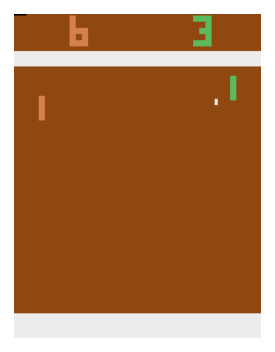

In [11]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)